In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from pyspark.sql.types import IntegerType
import pandas as pd
plt.rcParams['axes.xmargin'] = 0

In [3]:
appName = "hive_pyspark"
master = "local"
spark = SparkSession.builder.master(master).appName(appName).enableHiveSupport().getOrCreate()

23/01/08 11:23:36 WARN util.Utils: Your hostname, node1 resolves to a loopback address: 127.0.0.1; using 192.168.137.186 instead (on interface ens3)
23/01/08 11:23:36 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/01/08 11:23:37 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
tables = spark.sql("show tables").show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
| default|available_symbols...|      false|
| default|         binance_old|      false|
| default|           employees|      false|
| default|external_table_trams|      false|
| default|              kucoin|      false|
| default|             kucoin2|      false|
| default|          kucoin_old|      false|
| default|            salaries|      false|
| default|                wifi|      false|
| default|               wifi1|      false|
| default|               wifi2|      false|
| default|            wifi_par|      false|
+--------+--------------------+-----------+



In [5]:
CRYPTO = 'ETH'
QUOTE = 'USDT'

## Przygotowanie danych

In [6]:
binance = spark.sql(f"SELECT CAST(price AS double), timestamp_ FROM binance_old WHERE timestamp_ > 1672771237545 AND timestamp_ < 1672866000000 AND symbol='{CRYPTO}{QUOTE}'")
kucoin = spark.sql(f"SELECT CAST(price AS double), timestamp_ FROM kucoin_old WHERE timestamp_ > 1672771237545 AND timestamp_ < 1672866000000 AND symbol='{CRYPTO}-{QUOTE}'")

In [7]:
binance = binance.withColumn('timestamp', col('timestamp_') / 1000).drop(col('timestamp_'))
binance = binance.withColumn("timestamp", binance.timestamp.cast(IntegerType()))
binance = binance.withColumnRenamed('price', 'binance_price')
binance.show()

+-------------+----------+
|binance_price| timestamp|
+-------------+----------+
|       1210.9|1672779495|
|       1210.9|1672779501|
|      1211.07|1672779506|
|      1211.23|1672779512|
|      1211.24|1672779517|
|      1211.24|1672779523|
|      1211.23|1672779528|
|      1211.23|1672779534|
|      1211.23|1672779539|
|      1211.02|1672779544|
|      1211.02|1672779550|
|      1211.02|1672779555|
|      1211.01|1672779561|
|       1211.0|1672779566|
|       1211.0|1672779572|
|       1211.0|1672779577|
|       1211.0|1672779583|
|       1211.0|1672779588|
|       1211.0|1672779593|
|      1211.01|1672779599|
+-------------+----------+
only showing top 20 rows



In [8]:
kucoin = kucoin.withColumn('timestamp_kucoin', col('timestamp_') / 1000).drop(col('timestamp_'))
kucoin = kucoin.withColumn("timestamp_kucoin", kucoin.timestamp_kucoin.cast(IntegerType()))
kucoin = kucoin.withColumnRenamed('price', 'kucoin_price')
kucoin.show()

+------------+----------------+
|kucoin_price|timestamp_kucoin|
+------------+----------------+
|     1207.63|      1672772434|
|     1207.61|      1672772440|
|     1207.61|      1672772444|
|     1207.99|      1672772452|
|     1207.99|      1672772457|
|     1207.99|      1672772463|
|     1209.92|      1672775155|
|     1209.93|      1672775161|
|     1209.92|      1672775168|
|     1210.13|      1672775173|
|     1209.97|      1672775178|
|     1210.15|      1672775184|
|     1208.71|      1672775124|
|     1209.19|      1672775129|
|     1209.19|      1672775135|
|     1209.19|      1672775140|
|     1209.73|      1672775147|
|     1209.92|      1672775152|
|     1207.89|      1672773842|
|     1207.89|      1672773848|
+------------+----------------+
only showing top 20 rows



In [9]:
joined_dfs = binance.join(kucoin, binance.timestamp == kucoin.timestamp_kucoin, "inner").drop('timestamp_kucoin')
joined_dfs.show()

+-------------+----------+------------+
|binance_price| timestamp|kucoin_price|
+-------------+----------+------------+
|      1207.33|1672773246|     1206.93|
|      1209.66|1672775861|      1209.7|
|      1209.58|1672775337|     1209.54|
|      1207.57|1672773018|     1207.66|
|      1207.25|1672771896|      1207.3|
|       1210.7|1672776386|     1210.62|
|      1207.95|1672772371|     1207.93|
|      1210.76|1672779293|     1210.96|
|      1207.97|1672773449|     1207.79|
|      1209.17|1672775253|     1209.14|
|       1211.5|1672778694|     1211.31|
|      1207.66|1672772265|     1207.71|
|      1210.12|1672776481|     1210.12|
|      1207.34|1672771854|     1207.45|
|      1207.85|1672773848|     1207.89|
|      1210.23|1672775776|     1210.27|
|      1207.32|1672772606|      1207.6|
|      1207.37|1672774814|     1207.25|
|      1209.52|1672775295|     1209.53|
|      1209.57|1672775374|     1209.55|
+-------------+----------+------------+
only showing top 20 rows



In [10]:
joined_dfs = joined_dfs.withColumn('datetime', from_unixtime(col("timestamp"), 'MM-dd-yyyy HH:mm:ss'))
joined_dfs.show()

+-------------+----------+------------+-------------------+
|binance_price| timestamp|kucoin_price|           datetime|
+-------------+----------+------------+-------------------+
|      1207.33|1672773246|     1206.93|01-03-2023 19:14:06|
|      1209.66|1672775861|      1209.7|01-03-2023 19:57:41|
|      1209.58|1672775337|     1209.54|01-03-2023 19:48:57|
|      1207.57|1672773018|     1207.66|01-03-2023 19:10:18|
|      1207.25|1672771896|      1207.3|01-03-2023 18:51:36|
|       1210.7|1672776386|     1210.62|01-03-2023 20:06:26|
|      1207.95|1672772371|     1207.93|01-03-2023 18:59:31|
|      1210.76|1672779293|     1210.96|01-03-2023 20:54:53|
|      1207.97|1672773449|     1207.79|01-03-2023 19:17:29|
|      1209.17|1672775253|     1209.14|01-03-2023 19:47:33|
|       1211.5|1672778694|     1211.31|01-03-2023 20:44:54|
|      1207.66|1672772265|     1207.71|01-03-2023 18:57:45|
|      1210.12|1672776481|     1210.12|01-03-2023 20:08:01|
|      1207.34|1672771854|     1207.45|0

In [11]:
joined_dfs = joined_dfs.withColumn('minPrice', least(col('binance_price'), col('kucoin_price')))
joined_dfs = joined_dfs.withColumn('diff', col('binance_price') - col('kucoin_price'))
joined_dfs = joined_dfs.withColumn('absDiff', abs(col('diff')))
joined_dfs = joined_dfs.withColumn('absRelDiff', (col('absDiff') / col('minPrice')) * 100)
joined_dfs = joined_dfs.withColumn('relDiff', (col('diff') / col('minPrice')) * 100)
joined_dfs.show()

+-------------+----------+------------+-------------------+--------+--------------------+--------------------+--------------------+--------------------+
|binance_price| timestamp|kucoin_price|           datetime|minPrice|                diff|             absDiff|          absRelDiff|             relDiff|
+-------------+----------+------------+-------------------+--------+--------------------+--------------------+--------------------+--------------------+
|      1207.33|1672773246|     1206.93|01-03-2023 19:14:06| 1206.93|  0.3999999999998636|  0.3999999999998636| 0.03314193863768931| 0.03314193863768931|
|      1209.66|1672775861|      1209.7|01-03-2023 19:57:41| 1209.66|-0.03999999999996362| 0.03999999999996362|0.003306714283349...|-0.00330671428334...|
|      1209.58|1672775337|     1209.54|01-03-2023 19:48:57| 1209.54| 0.03999999999996362| 0.03999999999996362|0.003307042346674242|0.003307042346674242|
|      1207.57|1672773018|     1207.66|01-03-2023 19:10:18| 1207.57|-0.09000000000

In [12]:
joined_dfs.write.mode('overwrite').parquet(f"/user/kaluskam/project/pyspark/historical_data/{CRYPTO}{QUOTE}.parquet") 

## Wczytanie danych

In [13]:
df = spark.read.parquet(f"/user/kaluskam/project/pyspark/historical_data/{CRYPTO}{QUOTE}.parquet")
df.show()

+-------------+----------+------------+-------------------+--------+--------------------+--------------------+--------------------+--------------------+
|binance_price| timestamp|kucoin_price|           datetime|minPrice|                diff|             absDiff|          absRelDiff|             relDiff|
+-------------+----------+------------+-------------------+--------+--------------------+--------------------+--------------------+--------------------+
|      1207.24|1672771917|      1207.3|01-03-2023 18:51:57| 1207.24|-0.05999999999994543| 0.05999999999994543|0.004970014247369656|-0.00497001424736...|
|      1205.32|1672773162|     1206.83|01-03-2023 19:12:42| 1205.32|  -1.509999999999991|   1.509999999999991|   0.125277934490425|  -0.125277934490425|
|      1206.74|1672773199|      1207.0|01-03-2023 19:13:19| 1206.74| -0.2599999999999909|  0.2599999999999909|0.021545651921705662|-0.02154565192170...|
|      1208.67|1672773677|     1208.55|01-03-2023 19:21:17| 1208.55| 0.12000000000

## Wykresy

In [14]:
df_to_plot = df.toPandas()
df_to_plot.datetime = pd.to_datetime(df_to_plot['datetime'])

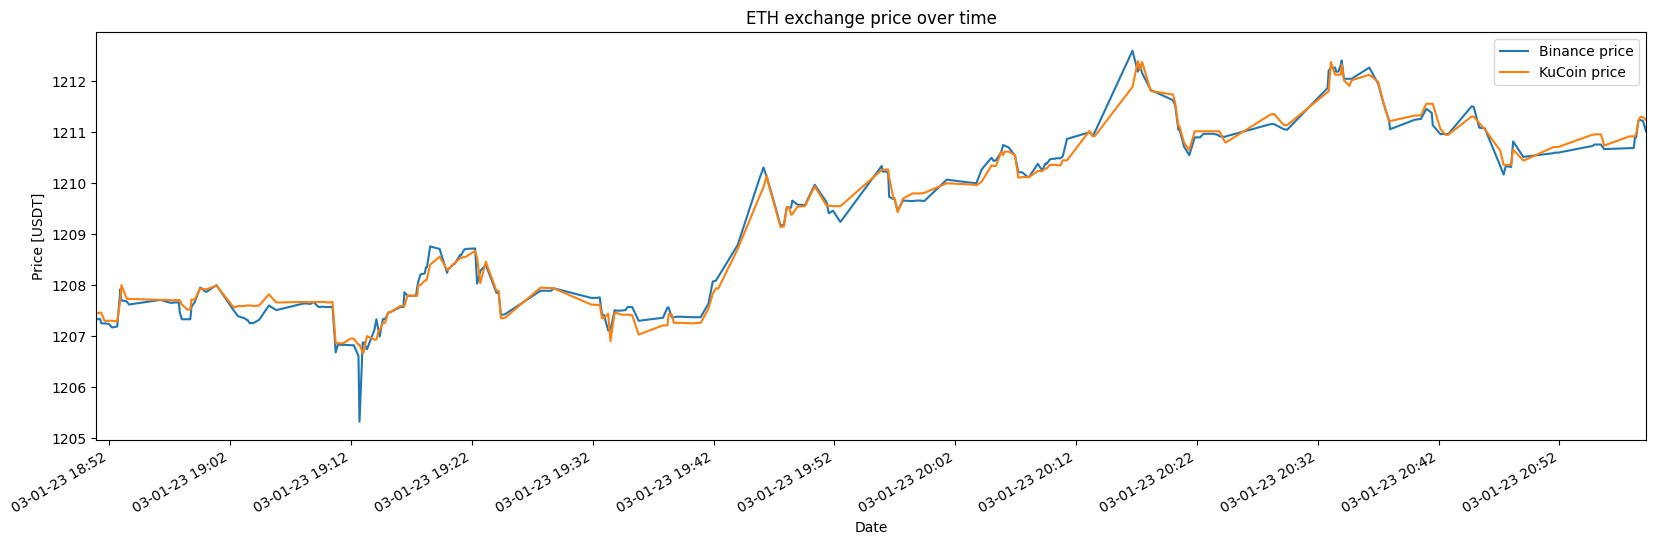

In [15]:
plt.rcParams["figure.figsize"] = (20,6)
ax = df_to_plot.plot.line(x='datetime', y=['binance_price', 'kucoin_price'], title=f'{CRYPTO} exchange price over time', x_compat=True)
ax.set_xlabel('Date')
ax.set_ylabel(f'Price [{QUOTE}]')
ax.legend(['Binance price', 'KuCoin price'])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
plt.xticks(rotation = 45)
plt.gcf().autofmt_xdate()
plt.savefig(f'{CRYPTO}_overtime.jpg', dpi=300)

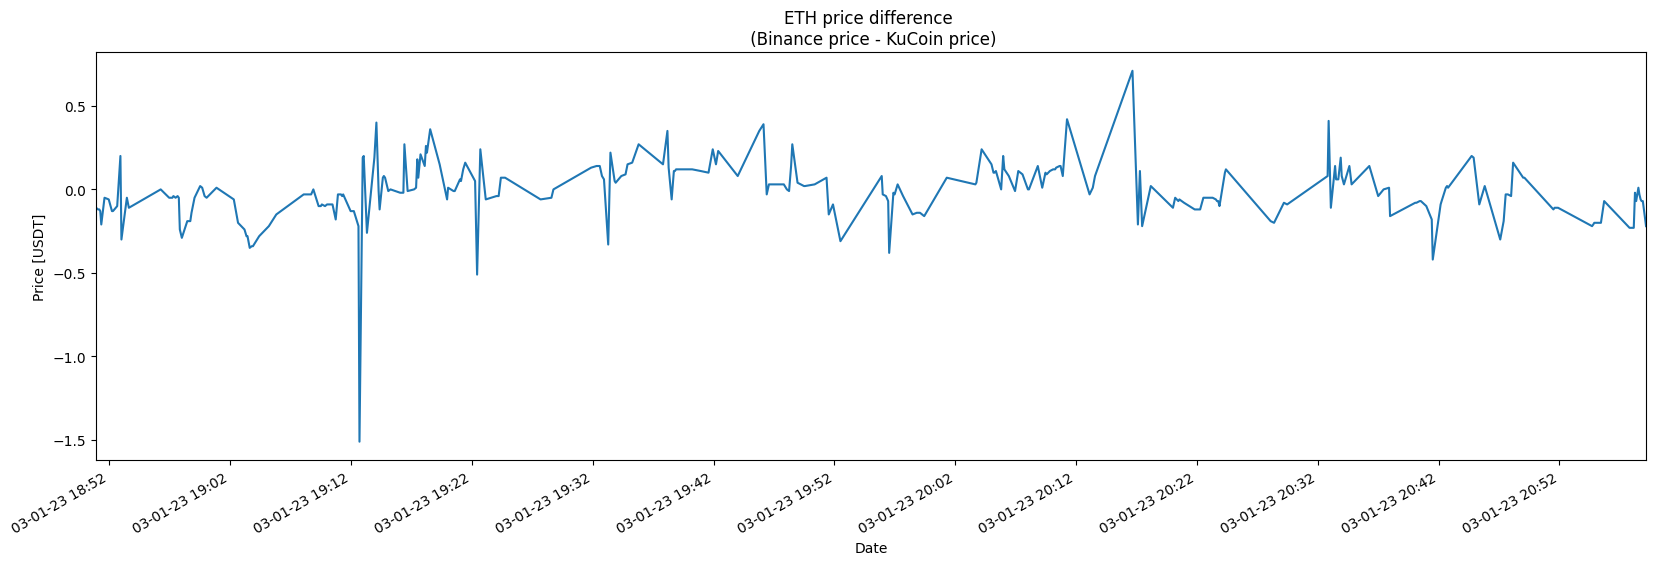

In [16]:
ax = df_to_plot.plot.line(x='datetime', y='diff', title=f'{CRYPTO} price difference \n (Binance price - KuCoin price)', x_compat=True)
ax.set_xlabel('Date')
ax.set_ylabel(f'Price [{QUOTE}]')
ax.get_legend().remove()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
plt.xticks(rotation = 45)
plt.gcf().autofmt_xdate()
plt.savefig(f'{CRYPTO}_diff.jpg', dpi=300)

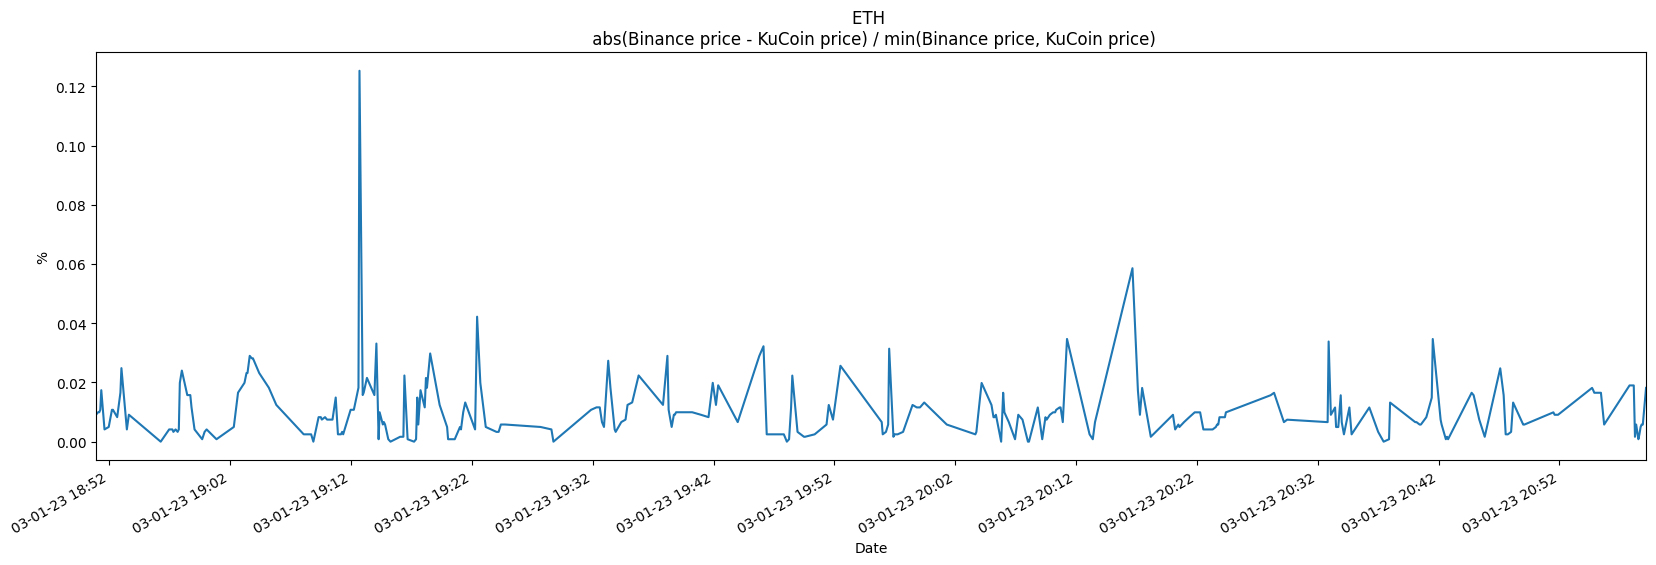

In [17]:
ax = df_to_plot.plot.line(x='datetime', y='absRelDiff', title=f'{CRYPTO} \n abs(Binance price - KuCoin price) / min(Binance price, KuCoin price)', x_compat=True)
ax.set_xlabel('Date')
ax.set_ylabel('%')
ax.get_legend().remove()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
plt.xticks(rotation = 45)
plt.gcf().autofmt_xdate()
plt.savefig(f'{CRYPTO}_abs_rel_diff.jpg', dpi=300)

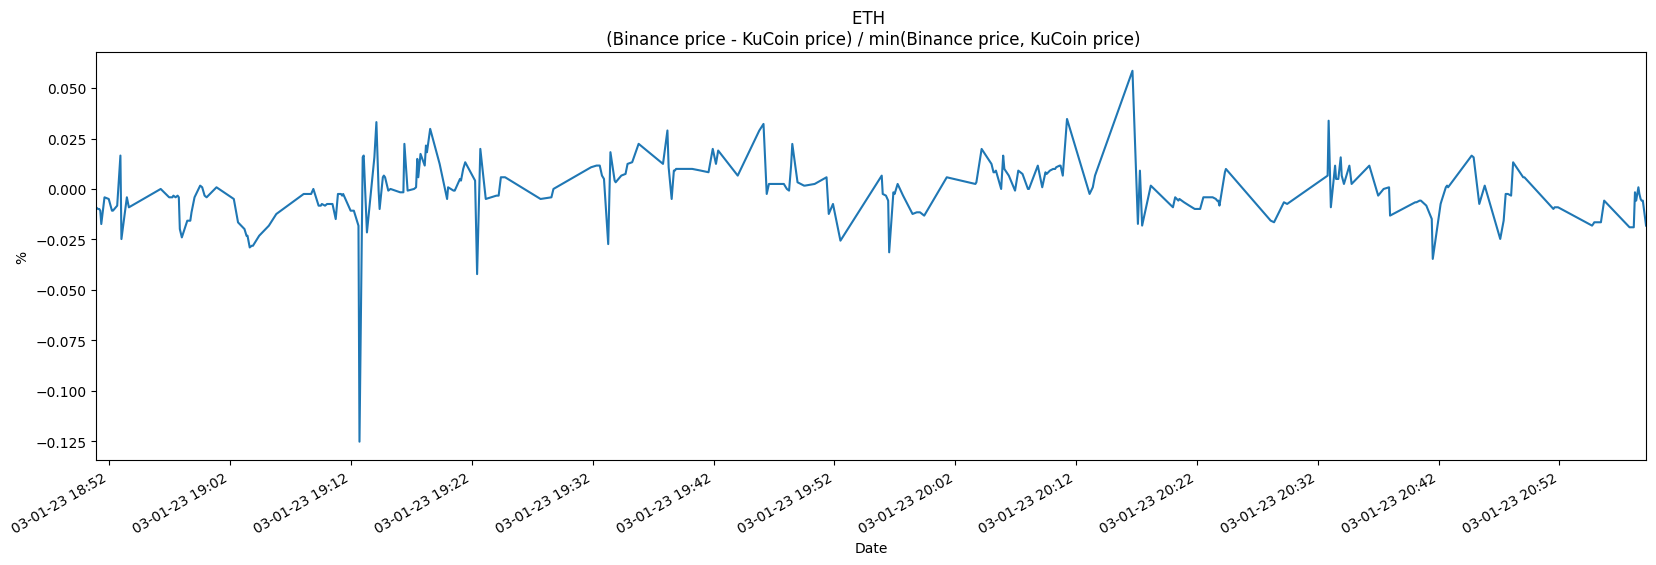

In [18]:
ax = df_to_plot.plot.line(x='datetime', y='relDiff', title=f'{CRYPTO} \n (Binance price - KuCoin price) / min(Binance price, KuCoin price)', x_compat=True)
ax.set_xlabel('Date')
ax.set_ylabel('%')
ax.get_legend().remove()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
plt.xticks(rotation = 45)
plt.gcf().autofmt_xdate()
plt.savefig(f'{CRYPTO}_rel_diff.jpg', dpi=300)